In [12]:
from ngsolve import *
from ngsolve.meshes import Make1DMesh
import matplotlib.pyplot as plt
import numpy as np
import time as timeit
from aux import *

import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 12}

matplotlib.rc('font', **font)
%matplotlib notebook

ngsglobals.msg_level=1

def FVSolveBot(case=2, nx=200, k = 0, cfl=0.5, method ="RK2", 
               eps0 = 1e-12, maxV = 10, epsRho=5e-3, plot=False, 
               tol = 0.02, flag="char", pcBot=False, limitB=True):
    time = 0
    count = 0
    g = 9.812
    eps = (2/g)**0.5
    
    if case=='1a': # Ex5.2 (a) well-balance test
        tend = 0.5
        uI = 0*x
        b0 = 5*exp(-0.4*(x-5)**2)
        rhobI = 10+0*x
        rhoI = rhobI-b0
        xL = 0
        xR = 10
        tgrid = [tend,20]  
        bcflag="" # wall
    elif case=='1b': # Ex5.2 (b) well-balance test
        tend = 0.5
        uI = 0*x
        b0 = IfPos((x-4)*(x-8), 0, 4)
        rhobI = 10+0*x
        rhoI = rhobI-b0
        xL = 0
        xR = 10
        tgrid = [tend,20]  
        bcflag="" # wall
    elif case == "2a": # Ex 5.3 (a) small perturbation with smooth  bot
        tend = 0.2
        delta = 1e-3
        b0 = IfPos((x-1.4)*(x-1.6), 0, 0.25*(cos(10*pi*(x-1.5))+1))
        rhobI = 1 + delta*IfPos((x-1.1)*(x-1.2), 0, 1)
        rhoI = rhobI-b0
        uI = 0*x
        xL = 0
        xR = 2
        tgrid = [tend,100]
        bcflag="" # wall
    elif case == "2b": # Ex 5.3 (b) small perturbation with smooth  bot
        tend = 0.2
        delta = 0.2
        b0 = IfPos((x-1.4)*(x-1.6), 0, 0.25*(cos(10*pi*(x-1.5))+1))
        rhobI = 1 + delta*IfPos((x-1.1)*(x-1.2), 0, 1)
        rhoI = rhobI-b0
        uI = 0*x
        xL = 0
        xR = 2
        tgrid = [tend,100]
        bcflag="" # wall
    elif case == "3a": # (Ex 5.4) dam break 1D
        tend = 60
        b0 = IfPos((x-750)**2-187.5**2, 0, 8)
        rhobI = IfPos(x-750, 15, 20)
        rhoI = rhobI-b0
        uI = 0*x
        xL = 0
        xR = 1500
        tgrid = [tend,100]
        bcflag="" #wall
    elif case =="4a": #(Ex5.5)  Riemann problem with const bot 1 (wetting/drying)
        tend = 12
        b0 = 0*x
        rhobI = IfPos(x, eps0, 10)
        rhoI = rhobI
        uI = 0*x
        xL = -300
        xR = 300
        tgrid = [4,8,12,20]
        bcflag="" #wall
    elif case =="4b": # Another Riemann problem with const bot 2
        tend = 6
        b0 = 0*x
        rhobI = IfPos(x, 10, 5)
        rhoI = rhobI
        uI = IfPos(x, 40, 0)
        xL = -200
        xR = 400
        tgrid = [2, 4,6,12]
        bcflag="right" #left: wall, right: outflow
    elif case =="4c": # (Ex 5.6) Riemann problem with const bot 2
        tend = 0.2
        g = 10
        b0 = 0*x
        rhobI = IfPos(x, 0.1, 1)
        rhoI = rhobI
        uI = 0*x
        xL = -1
        xR = 1
        tgrid = [tend,12]
        bcflag="" #wall

    # mesh
    h0 = (xR-xL)/nx
    mesh = Make1DMesh(n=nx, mapping=lambda x:xL+(xR-xL)*x)
    
    # point evaluation matrix
    mat = [] # no eval pts
    for i in range(1, k):
        if i%2==0:
            mat.append([1,1])
        else:
            mat.append([1,-1])
    mat = np.array(mat).T
    
    
    n = specialcf.normal(mesh.dim)
    # Burgers
    V = L2(mesh, order=k, all_dofs_together=False)
    fes = FESpace([V,V])

    bh = GridFunction(V)
    # default is an L2 proj
    if k==0 or pcBot==True: # piecewise constant data
        bhX = GridFunction(L2(mesh))
        rhohX = GridFunction(L2(mesh))
        bhX.Set(b0)
        bh.Set(bhX)
        rhohX.Set(rhobI)
        rhobI = rhohX
    elif k==1: # use CG linear bh
        helper = GridFunction(H1(mesh, order=1))
        vtxPts = np.linspace(xL, xR, nx+1)
        bVals = np.array([b0(mesh(x)) for x in vtxPts])
        helper.vec.FV().NumPy()[:] = bVals
        bh.Set(helper)

        rVals = np.array([rhobI(mesh(x)) for x in vtxPts])
        helper.vec.FV().NumPy()[:] = rVals
        rhobI = helper
    else: # use h.o. CG linear bh
        helper = GridFunction(H1(mesh, order=k))
        helper.Set(b0)
        bh.Set(helper)
        helper.Set(rhobI)
        rhobI = helper
    
    gfu = GridFunction(fes)
    gfu0 = GridFunction(fes)
    
    rhoh, uh = gfu.components
    rhoh0, uh0 = gfu0.components
    mh = GridFunction(V) # momentum
    mh0 = GridFunction(V) # momentum
        
    (rho, u), (eta, v) = fes.TnT()

    ### LF flux
    rhoO = rho.Other(rhoI)
    uO = u.Other(uI)

    avg_u = 0.5*(u+uO)

    # Hydro static reconstruction
    if k==0 or pcBot==True: # THIS GUARANTEE POSITIVITY
        maxB = IfPos(bh-bh.Other(), bh, bh.Other())
        rhoL = IfPos(rho+bh-maxB, rho+bh-maxB, 0)
        rhoR = IfPos(rhoO+bh.Other()-maxB, rhoO+bh.Other()-maxB, 0)
        jmp_rho = rhoL-rhoR
        avg_rho = 0.5*(rhoL+rhoR)
    else:
        rhoL = rho
        rhoR = rhoO
        jmp_rho = rho-rhoO+bh-bh.Other()
        avg_rho = 0.5*(rho+rhoO+bh+bh.Other())
    
    cL = (2*rhoL)**0.5/eps
    cR = (2*rhoR)**0.5/eps
    abs_uL = IfPos(u, u, -u)
    abs_uR = IfPos(uO, uO, -uO)
    
    speedL = cL+abs_uL
    speedR = cR+abs_uR

    ### ESTIMATE SPEED ?! FIXME LATER
    speed_rho = IfPos(speedL-speedR, speedL, speedR)        
    speed_u = speed_rho    
    
    # EEC flux + stab (LLF)
    flux_rho = 0.5*(rhoL*u+rhoR*uO)*n + 0.5*speed_rho*jmp_rho
    flux_m = flux_rho*avg_u + 0.5*speed_u*avg_rho*(u-uO)
    
    # Spatial operator (for rho updates)
    a = BilinearForm(fes)
    # mass eqn
    if k>0:
        # volume integration -- eqn 1
        a += -rho*u*grad(eta)*dx
        # volume integration -- eqn 2 (convection)
        a += (-0.5*rho*u**2*grad(v)+0.5*rho*u*grad(u)*v)*dx
        # volume integration -- eqn 2 (gravitation)
        a += g*(grad(rho)+grad(bh))*rho*v*dx
        
    # interial node integration -- eqn 1    
    a += flux_rho*(eta-eta.Other())*dx(skeleton=True)
    
    # interial node integration -- eqn2 (convection-- part 1)
    a += flux_m*(v-v.Other())*dx(skeleton=True)
    # interial node integration -- eqn2 (convection-- part 2)
    a += -0.5*flux_rho*(u*v-uO*v.Other())*dx(skeleton=True)
    # interial node integration -- eqn2 (gravitation)
    a += -g*jmp_rho*n*0.5*(rhoL*v+rhoR*v.Other())*dx(skeleton=True)
    
        
    # Boundary parts -- eqn1 & eqn2
    # outflow boundary condition
    a += flux_rho*eta*ds(skeleton=True, definedon=mesh.Boundaries(bcflag))
    a += (flux_m*v-0.5*flux_rho*u*v)*ds(skeleton=True, definedon=mesh.Boundaries(bcflag))
        
    ### INITIAL DATA (HACK)
    uh.Set(uI)
    rhoh.Set(rhobI)     
    rhoh.vec.data -= bh.vec # remove bottom
    
    ### HACK: use P0 for height < epsRho*hMax
    epsRho *= max(rhoh.vec[:nx].FV().NumPy())
#     print("Low-order cut:", epsRho)

    # add mh
    mh.vec.data = uh.vec
    V.ApplyM(rho=rhoh, vec=mh.vec)
    V.SolveM(rho=1, vec=mh.vec)
    
    tmp = gfu.vec.CreateVector()
    
    tmpU = uh.vec.CreateVector()
    tmpU0 = uh.vec.CreateVector()
    tmpU1 = uh.vec.CreateVector()
    nrho = V.ndof

    step = 0

    vel = GridFunction(L2(mesh))
    vel.Set((2*rhoh)**0.5/eps+((uh)**2)**0.5)
    dt = cfl*h0/max(vel.vec)

    ## PP limiter preparation
    ir = [1, 0]
    if k>1:
        ir0 = IntegrationRule(SEGM, order=2*k)
        for p0 in ir0.points:
            ir.append(p0[0])
    mips = getVerts1D(mesh, ir)
    npts = len(ir)
    
    N = ceil((3+k)/2)
    mw = 1/N/(N-1) # lobato quad weights
    
    nelems = mesh.ne
    # cell center points for ploting
    pnts_x = np.linspace(xL+0.5*h0, xR-0.5*h0, nx)              
    
    pnts_rho = []
    pnts_b = []
    pnts_u = [] 
    pnts_m = [] 
    
    listNbs = getNeighbors1D(mesh)            
        
    def ForwardEuler(dt):
        # evaluate the bilinear form
        a.Apply(gfu.vec, tmp)
        # tmpU is rho_old * u_old *v
        tmpU.data = uh.vec
        V.ApplyM(rho=rhoh, vec=tmpU)
        tmp[nrho:].data += 0.5/dt*tmpU
        
        # (1) solve for density inc.
        # (1) update density (unlimited)       
        V.SolveM(rho=1, vec=tmp[:nrho])       
        rhoh.vec.data -= dt*tmp[:nrho]
        
        # update derivative (use unlimited den)
        # tmpU is rho_new * u_old *v
        tmpU.data = uh.vec
        V.ApplyM(rho=rhoh, vec=tmpU)
        tmp[nrho:].data -= 0.5/dt*tmpU

        # update momentum (unlimited)
        V.SolveM(rho=1, vec=tmp[nrho:])
        mh.vec.data -= dt*tmp[nrho:]
    
    # convex combination
    def ConvexComb(w0, w1):
        # update density
        rhoh.vec.data *= w1
        rhoh.vec.data += w0*rhoh0.vec

        # update momentum
        mh.vec.data *= w1
        mh.vec.data += w0*mh0.vec
        
    def CalcVel():
        tmpU.data = mh.vec
        V.ApplyM(rho=1, vec=tmpU)
        V.SolveM(rho=rhoh, vec=tmpU)
        uh.vec.data = tmpU 
        if maxV >0:
            nlimit = limitU1D(uh, nelems, k, mat, maxV=maxV)
        else:
            nlimit = 0
        return nlimit

    # limit den + mh
    def Limit():
        if k > 0 and epsRho > 0:
            # (1) avg_rho < epsRho: use lowest order P0 approximation
            drylimit1D(rhoh, mh, k, nelems, epsRho=epsRho)
        
        # (2) tvb limit
        maskM, nlimit = tvbLimitM1D(rhoh, mh, bh, k, nelems, listNbs, tol, 
                                  flag=flag, g=g, epsRho=epsRho, limitB=limitB)
            
        # (3) pplimit
        pplimit(rhoh, k, mips, npts,  nelems, mw, eps0=eps0)
        return maskM, nlimit
        
    if plot==True:
        pb = np.array([bh(x) for x in pnts_x])
        prho = np.array([rhoh(x) for x in pnts_x])
        pu = np.array([uh(x) for x in pnts_x])
        pm = np.array([mh(x) for x in pnts_x])
        fig = plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        line1, = ax1.plot(pnts_x, prho+pb,'b+-')
        line2, = ax2.plot(pnts_x, pm,'b+-')
        line3, = ax1.plot(pnts_x[5], prho[5],'r+')
        if case=="2a":
            ax1.set_ylim([0.999,1.001])
            ax2.set_ylim([-0.002,0.002])
        elif case=="2b":
            ax1.set_ylim([0.8,1.2])
            ax2.set_ylim([-0.5,0.5])
            
    mask, nlimit= 0,0
    with TaskManager():
        while time < tend+dt/2:
            if dt < 1e-6:
                print("Too small time step size")
                break
            time += dt
            step += 1
            gfu0.vec.data = gfu.vec
            mh0.vec.data = mh.vec

            ### RK3 stage 1
            ForwardEuler(dt)
            mask, nlimit = Limit() 
            # update vel
            nlimitU = CalcVel()
            
            # check min rho
            rhomin = min(rhoh.vec[:nelems])
            if rhomin < 0 :
                print("Stage 1 @step: %4.0f time: %2.3e, rhoMin:%.2e, dt:%.2e"%(step, time, rhomin, dt))
                # Half time step
                gfu.vec.data = gfu0.vec
                mh.vec.data = mh0.vec
                time -= dt
                step -= 1
                dt /= 2
                continue
            
            ## RK2
            if method !="RK1":
                ForwardEuler(dt)
                rhomin = min(rhoh.vec[:nelems])
                if rhomin < 0 :
                    print("Stage 2 @step: %4.0f time: %2.3e, rhoMin:%.2e, dt:%.2e "%(step, time, rhomin,dt))
                    # Half time step
                    gfu.vec.data = gfu0.vec
                    mh.vec.data = mh0.vec
                    time -= dt
                    step -= 1
                    dt /= 2                    
                    continue

                # RK2 update: HOW TO KEEP momentum conservation?
                if method=="RK2":
                    ConvexComb(0.5, 0.5)
                    Limit() 
                    # update vel
                    CalcVel()
                else: 
                    ConvexComb(0.75, 0.25)
                    Limit() 
                    # update vel
                    CalcVel()
                
                    # Stage 3
                    ForwardEuler(dt)
                    rhomin = min(rhoh.vec[:nelems])
                    if rhomin<0 :
                        print("Stage 3 @step: %4.0f time: %2.3e, rhoMin:%.2e, dt:%.2e "%(step, time, 
                                                                                               rhomin,dt))
                        # Half time step
                        gfu.vec.data = gfu0.vec
                        mh.vec.data = mh0.vec
                        time -= dt
                        step -= 1
                        dt /= 2
                        continue
                    # convex combination
                    ConvexComb(1/3, 2/3)
                    mask, nlimit = Limit() 
                    # update vel
                    nlimitU = CalcVel()
            
            # estimate based on cell-averages        
            vel.Set((2*rhoh)**0.5/eps+((uh)**2)**0.5)
            vmax = max(vel.vec)
            dt = cfl*h0/vmax
            rhomin = min(rhoh.vec[:mesh.ne])
#             print("\r", "time: %.3e, step:%4i, vmax: %.2e nlimit: %4i %4i"%(time, step, 
#                                                                             vmax, nlimit, nlimitU),end="")
            if rhomin<0 or vmax > 1000:
                id0 = np.argmax(vel.vec.FV().NumPy())
                print("\n")
                print(np.isnan(Norm(rhoh.vec)), np.isnan(Norm(mh.vec)), 
                      np.isnan(Norm(uh.vec)), rhoh.vec[id0-1:id0+2], mh.vec[id0-1:id0+2], uh.vec[id0-1:id0+2])
                print("negative density/too large velocity... OPPS")
                break
            if time > tgrid[count]-dt/2:
                count += 1
                prho = np.array([rhoh(x) for x in pnts_x])
                pb = np.array([bh(x) for x in pnts_x])
                pu = np.array([uh(x) for x in pnts_x])
                pm = np.array([mh(x) for x in pnts_x])
                pnts_rho.append(prho)
                pnts_b.append(pb)
                pnts_u.append(pu)
                pnts_m.append(pm)
            if plot==True and step%10 == 0:
                prho = np.array([rhoh(x) for x in pnts_x])
                pm = np.array([mh.vec[j] for j in range(nx)])
                line1.set_ydata(prho+pb)
                line2.set_ydata(pm)
                line3.set_xdata(pnts_x[mask])
                line3.set_ydata(prho[mask]+pb[mask])
                fig.canvas.draw()
                fig.canvas.flush_events()
                
            
        return pnts_x, pnts_rho, pnts_b, pnts_u, pnts_m, mask, rhoh, bh, uh, mh


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Examples:
- 1a,1b  (WB tests)
- 2a,2b  (Small perturbations)
- 3a     (disc. bot)
- 4a, 4b, 4c: Riemann problem with flat bot (4a is a dry test)


### Ex1a

In [11]:
# 1a)
nxList = [100, 200, 400]

case = '1a'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 0 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    # L2 errors
    errR = sqrt(Integrate((rhoh+bh-10)**2, rhoh.space.mesh))
    errU = sqrt(Integrate(uh**2, rhoh.space.mesh))
    errM = sqrt(Integrate(mh**2, rhoh.space.mesh))
    print("%3i& %.3e & %.3e & %.3e \\\\"%(100*2**i, errR, errU, errM))


100& 9.819e-14 & 7.380e-14 & 5.025e-13 \\
200& 1.747e-13 & 8.344e-14 & 6.331e-13 \\
400& 3.740e-13 & 1.328e-13 & 1.029e-12 \\


### Ex1b

In [3]:
# 1b)
nxList = [100, 200, 400]

case = '1b'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 0 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    # L2 errors
    errR = sqrt(Integrate((rhoh+bh-10)**2, rhoh.space.mesh))
    errU = sqrt(Integrate(uh**2, rhoh.space.mesh))
    errM = sqrt(Integrate(mh**2, rhoh.space.mesh))
    print("%3i& %.3e & %.3e & %.3e \\\\"%(100*2**i, errR, errU, errM))

100& 7.700e-14 & 7.627e-14 & 5.024e-13 \\
200& 1.805e-13 & 1.042e-13 & 8.494e-13 \\
400& 2.787e-13 & 2.153e-13 & 1.355e-12 \\


### Ex2b

In [40]:
# 2b) : large perturbation
nxList = [200, 2000]

case = '2b'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 0 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

# generate data
pnts_x = []
pnts_rho = []
pnts_b=[]
pnts_u=[]
pnts_m=[]
masks = []
for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    pnts_x.append(pnts_x0)
    pnts_rho.append(pnts_rho0[-1])
    pnts_b.append(pnts_b0[-1])
    pnts_u.append(pnts_u0[-1])
    pnts_m.append(pnts_m0[-1])
    masks.append(mask)

<IPython.core.display.Javascript object>


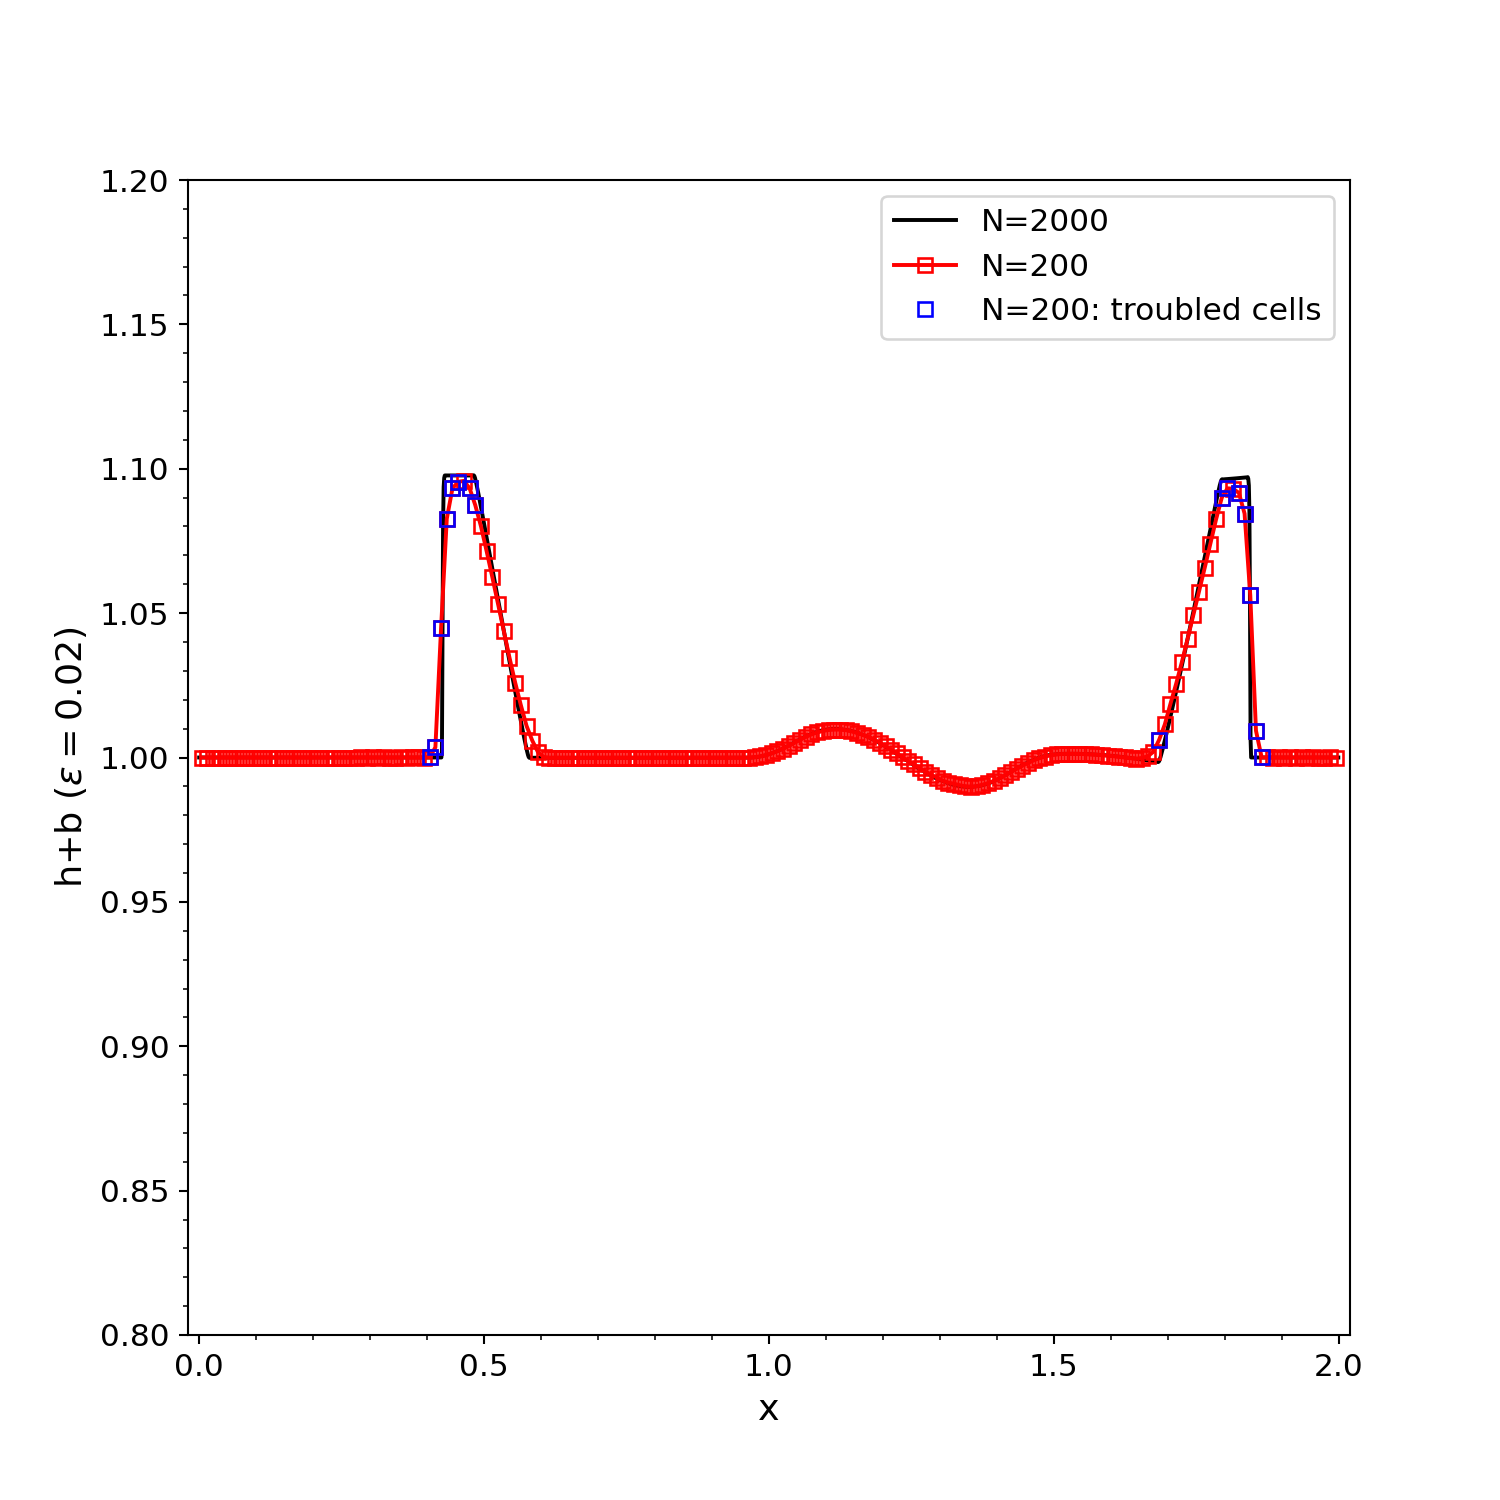

<IPython.core.display.Javascript object>


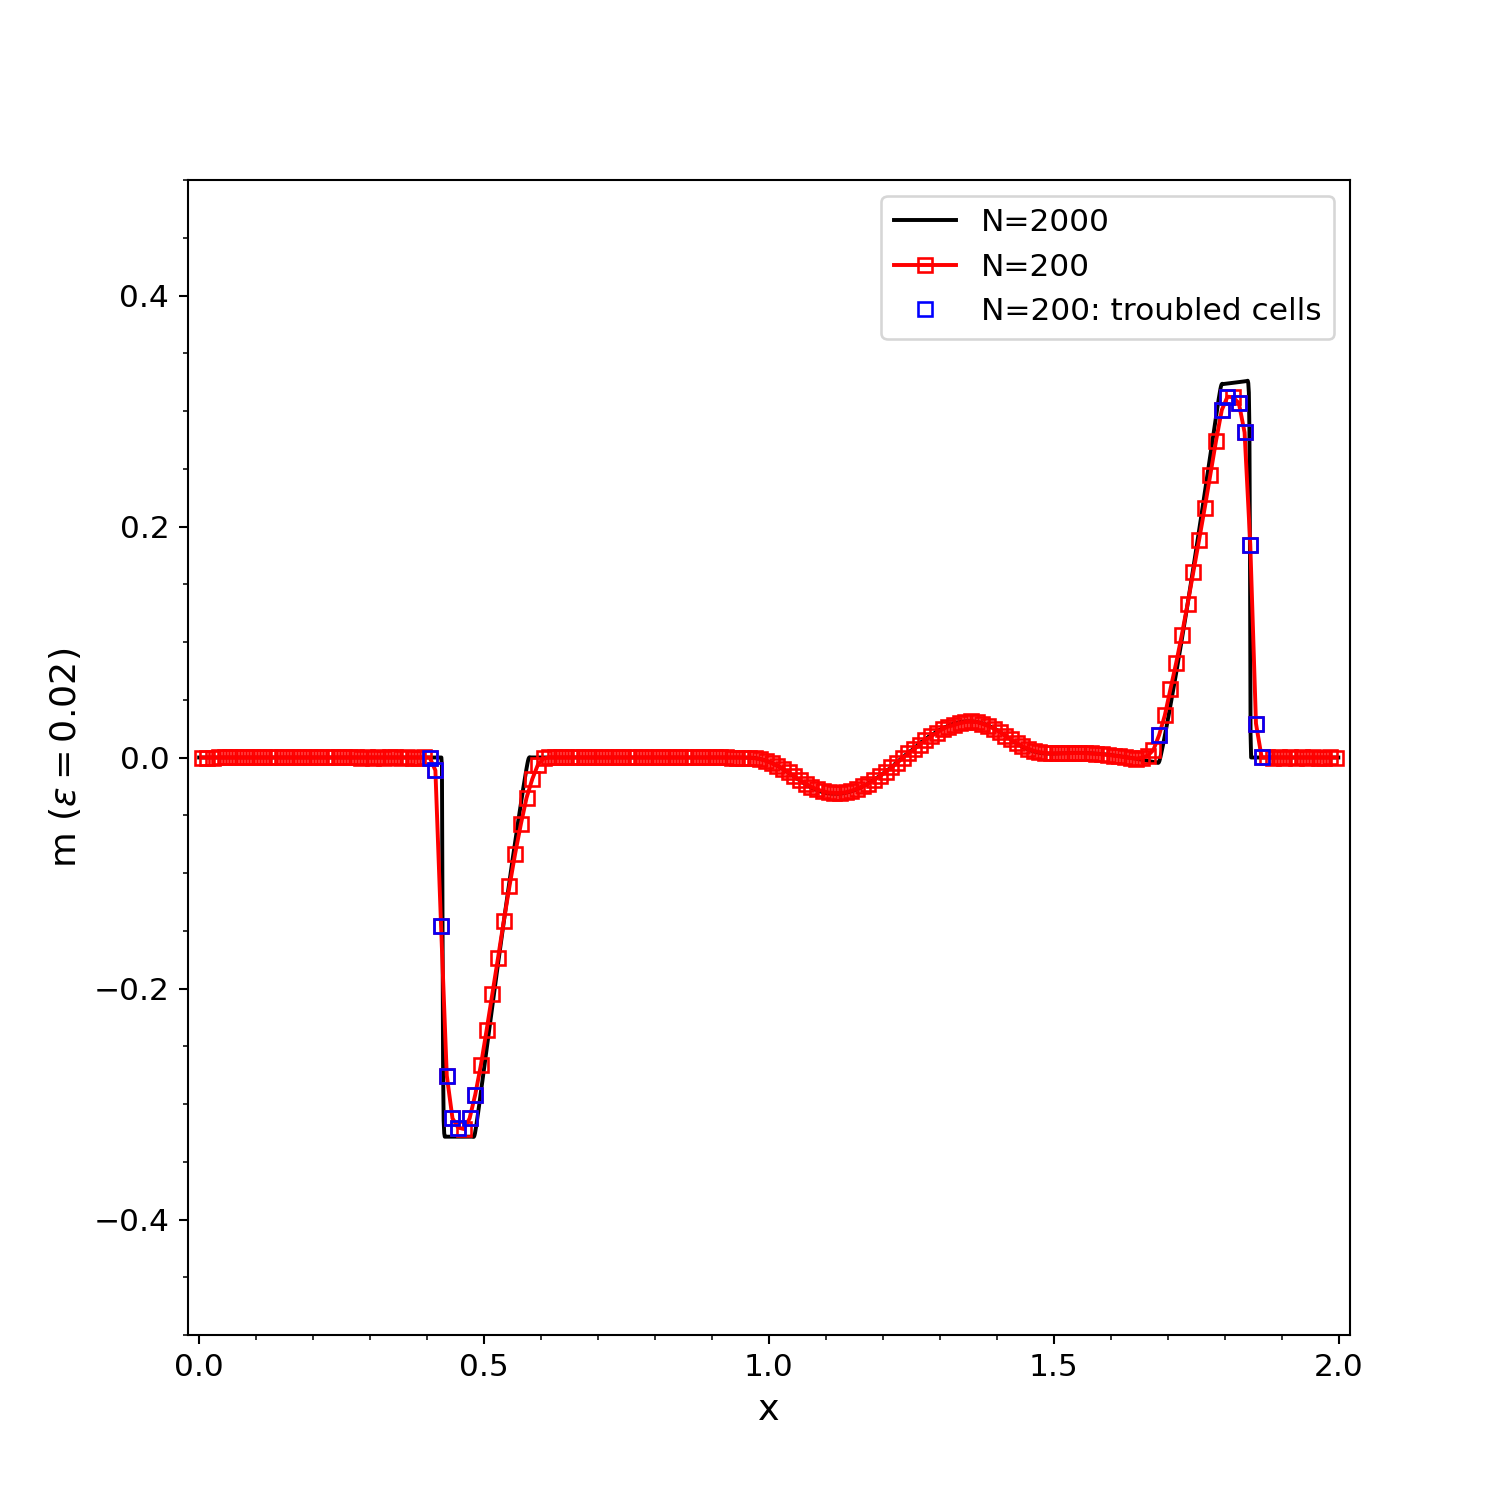

In [44]:
### 2b: plotting
### water height
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_rho[1]+pnts_b[1],'k-')
ax1.plot(pnts_x[0], pnts_rho[0]+pnts_b[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_rho[0][masks[0]]+pnts_b[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("h+b ($\epsilon=0.02$)", fontsize=14)
ax1.set_xlim([-0.02,2.02])
ax1.set_ylim([0.8,1.2])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("rho2b.pdf")


### discharge
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_m[1],'k-')
ax1.plot(pnts_x[0], pnts_m[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_m[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("m ($\epsilon=0.02$)", fontsize=14)
ax1.set_xlim([-0.02,2.02])
ax1.set_ylim([-0.5,0.5])
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.set_yticks([-0.4,-0.2,0, .2,0.4])
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("m2b.pdf")

### Ex2a

<IPython.core.display.Javascript object>


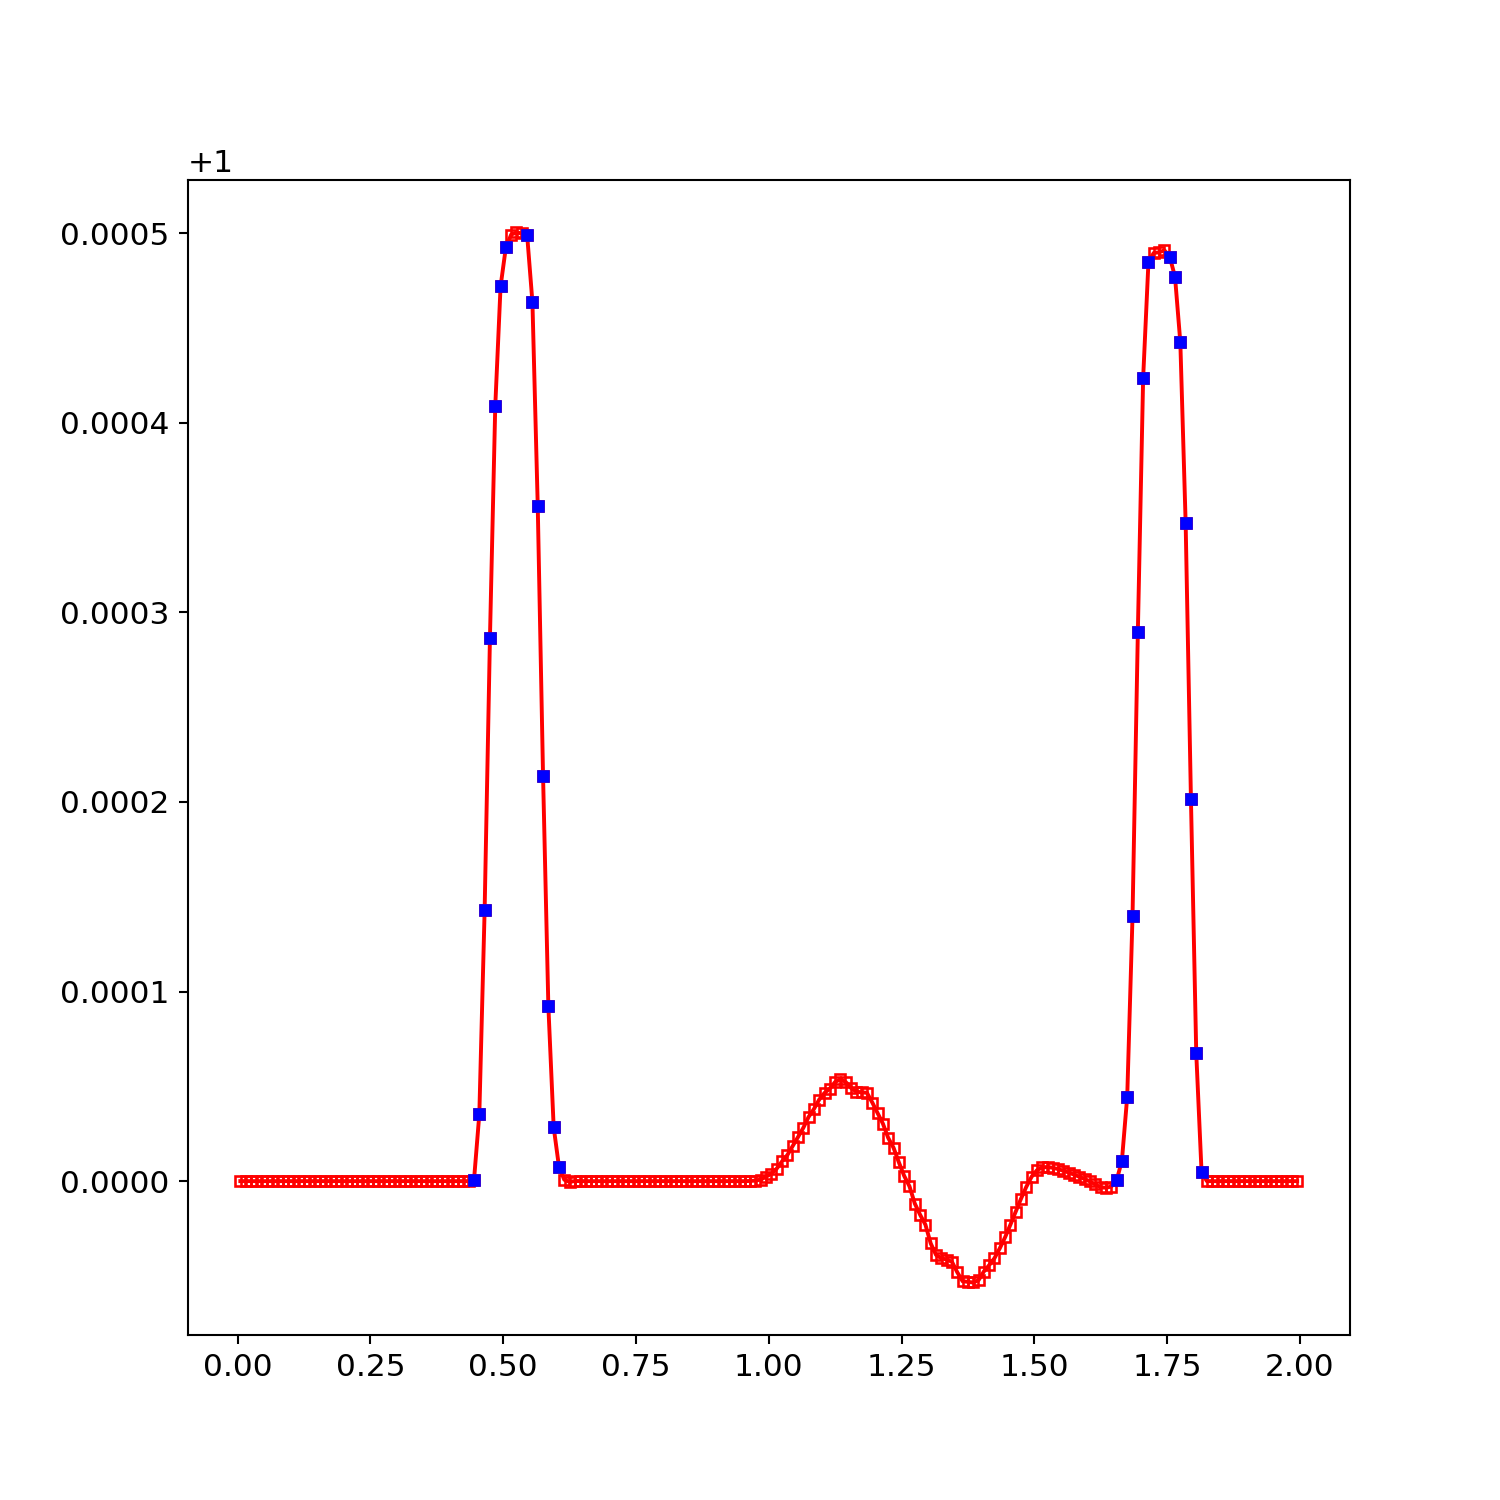

In [36]:
# 2a) : small perturbation
nxList = [200, 2000]

case = '2a'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 0 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

# generate data
pnts_x = []
pnts_rho = []
pnts_b=[]
pnts_u=[]
pnts_m=[]
masks = []
for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    pnts_x.append(pnts_x0)
    pnts_rho.append(pnts_rho0[-1])
    pnts_b.append(pnts_b0[-1])
    pnts_u.append(pnts_u0[-1])
    pnts_m.append(pnts_m0[-1])
    masks.append(mask)

<IPython.core.display.Javascript object>


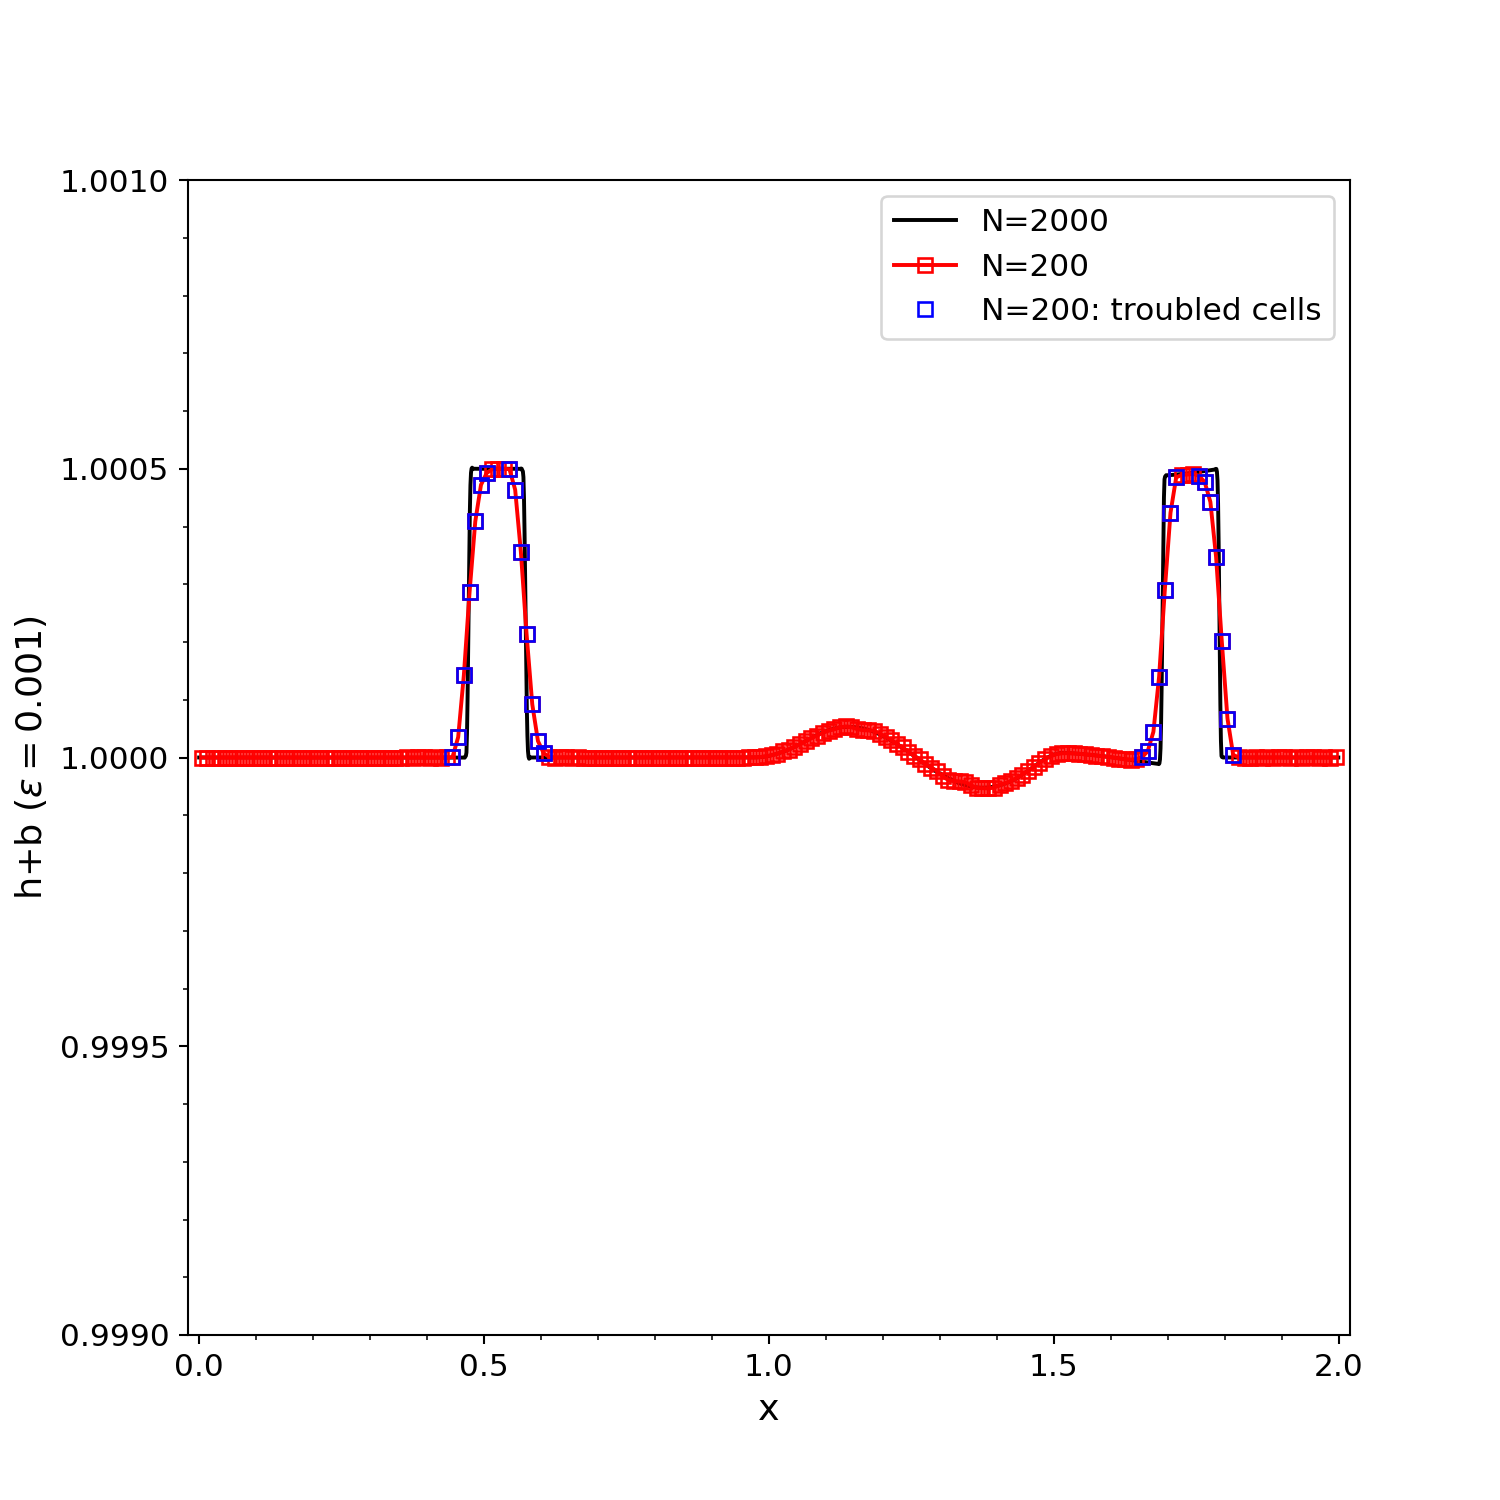

<IPython.core.display.Javascript object>


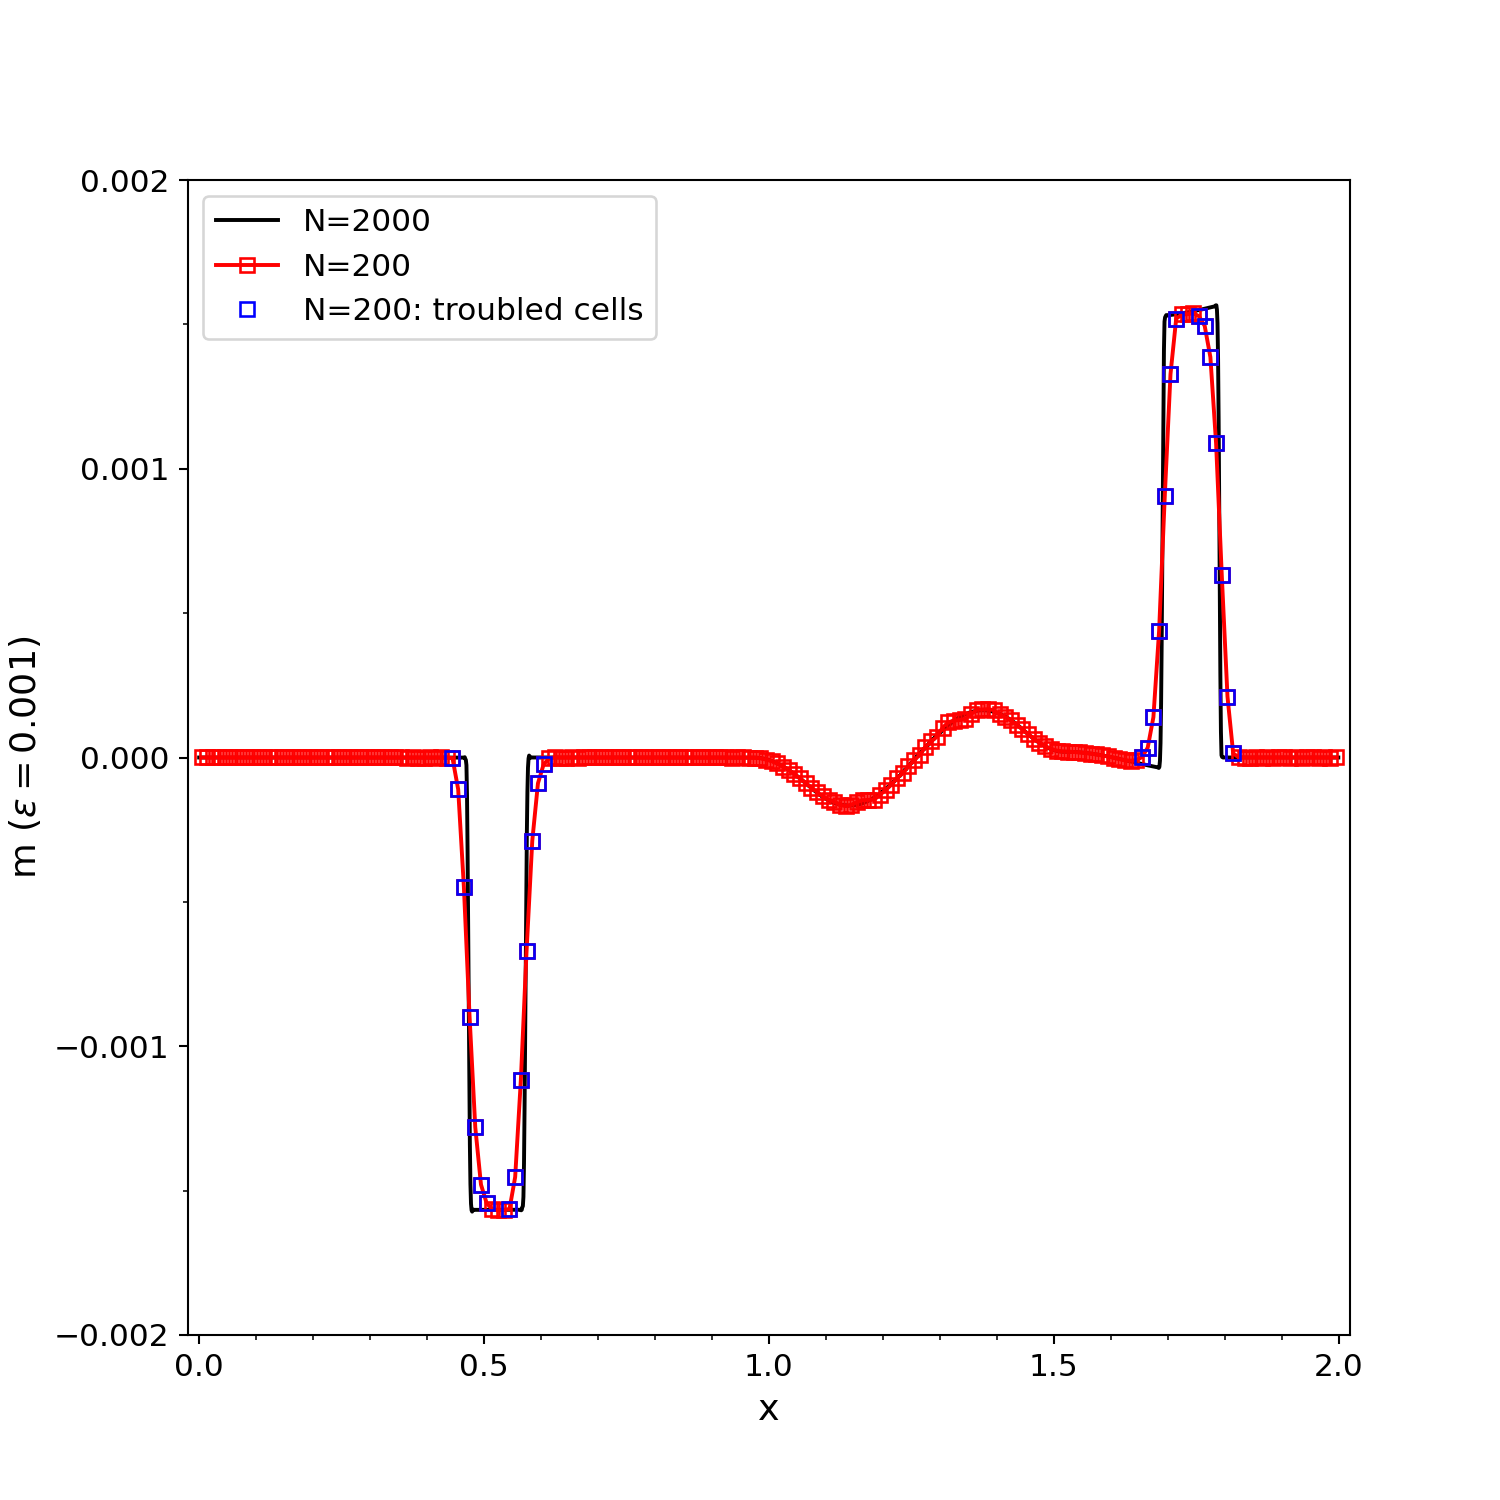

In [39]:
### 2a: plotting
### water height
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_rho[1]+pnts_b[1],'k-')
ax1.plot(pnts_x[0], pnts_rho[0]+pnts_b[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_rho[0][masks[0]]+pnts_b[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("h+b ($\epsilon=0.001$)", fontsize=14)
ax1.set_xlim([-0.02,2.02])
ax1.set_ylim([0.999,1.001])
ax1.set_xticks([0,0.5,1,1.5,2])
ax1.set_yticks([0.999,0.9995,1,1.0005,1.001])
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0001))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("rho2a.pdf")


### discharge
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_m[1],'k-')
ax1.plot(pnts_x[0], pnts_m[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_m[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("m ($\epsilon=0.001$)", fontsize=14)
ax1.set_xlim([-0.02,2.02])
ax1.set_ylim([-0.002,0.002])
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0005))
ax1.yaxis.set_major_locator(MultipleLocator(0.001))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("m2a.pdf")

### Ex3a

In [ ]:
# 3a) : discontinuous bottom
nxList = [200, 2000]

case = '3a'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 0 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

# generate data
pnts_x = []
pnts_rho = []
pnts_b=[]
pnts_u=[]
pnts_m=[]
masks = []
for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    pnts_x.append(pnts_x0)
    pnts_rho.append(pnts_rho0[-1])
    pnts_b.append(pnts_b0[-1])
    pnts_u.append(pnts_u0[-1])
    pnts_m.append(pnts_m0[-1])
    masks.append(mask)
    print(nx, "...done")

200 ...done


<IPython.core.display.Javascript object>


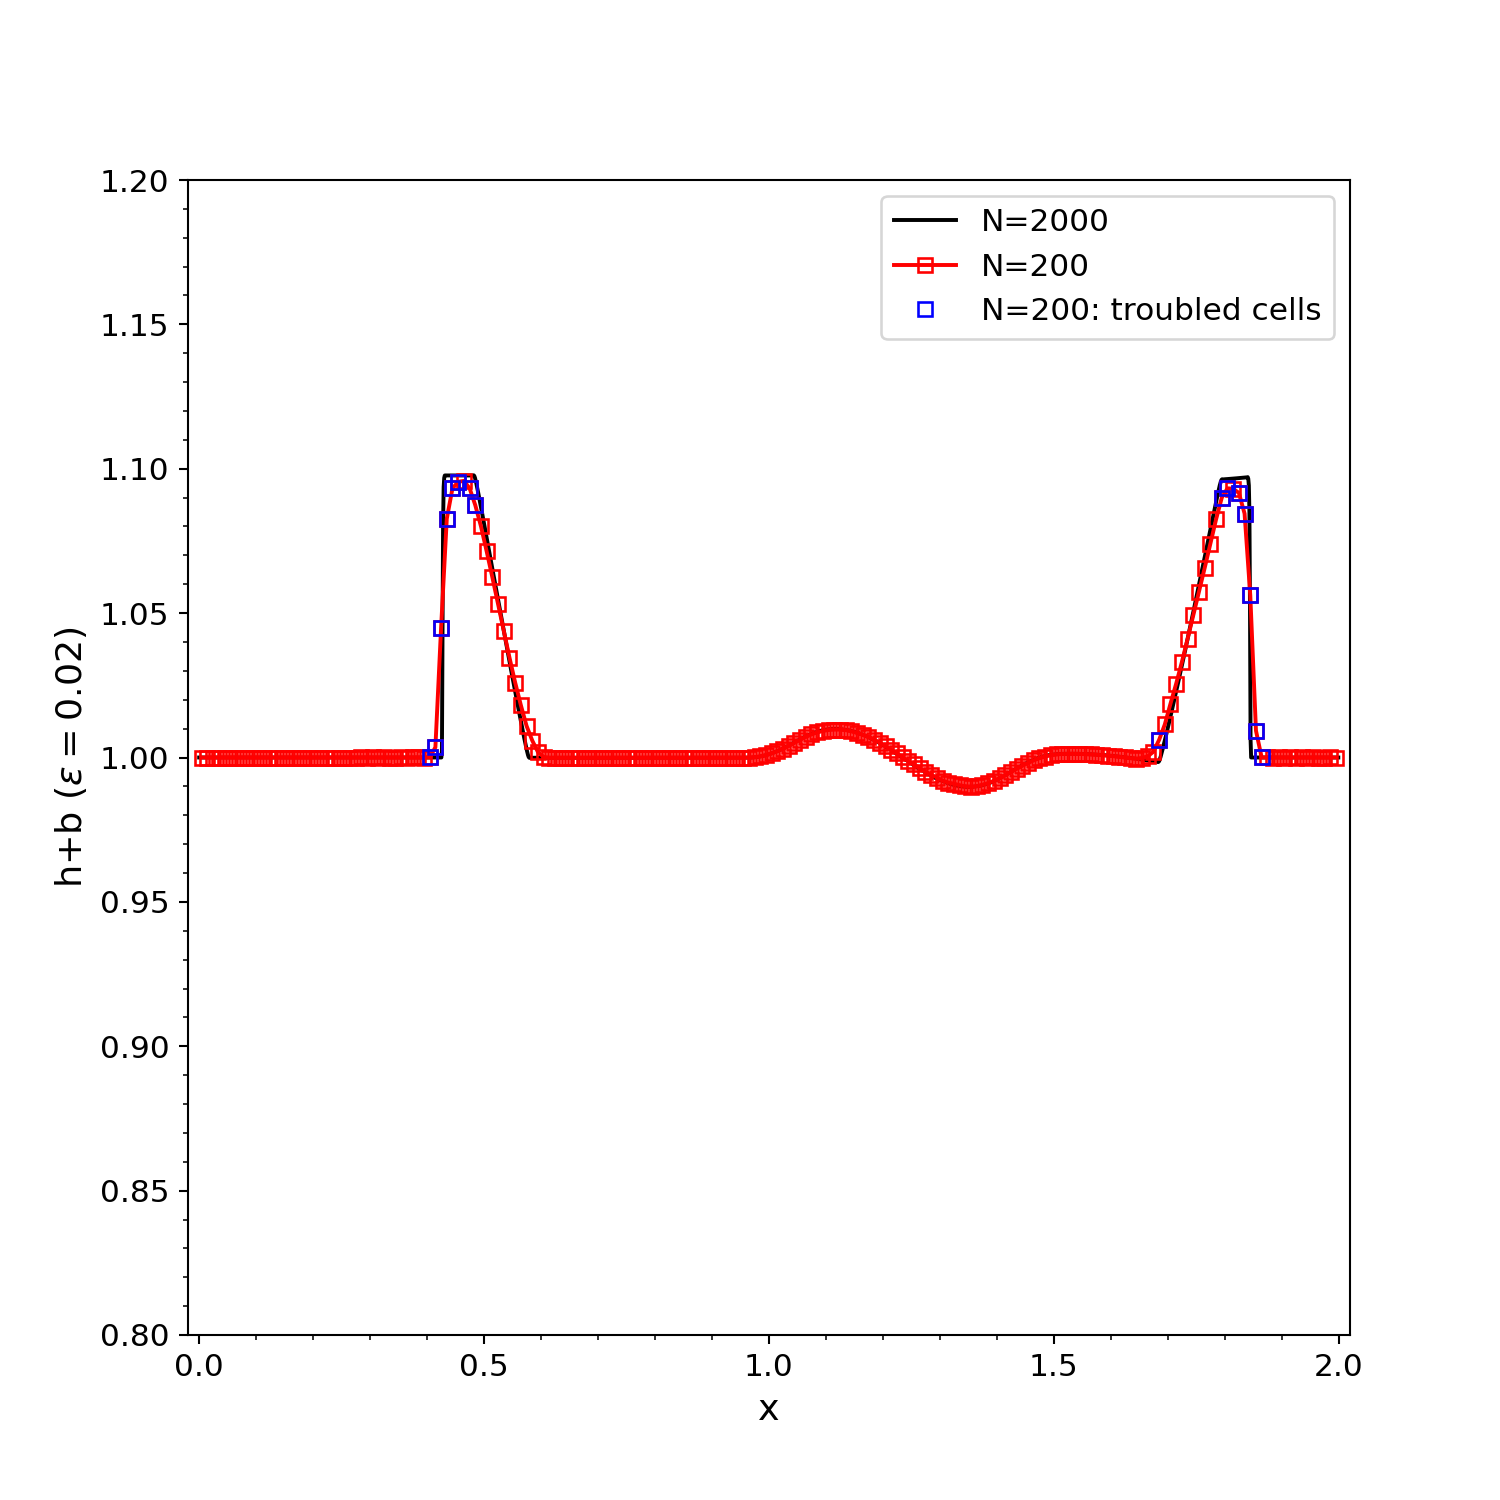

<IPython.core.display.Javascript object>


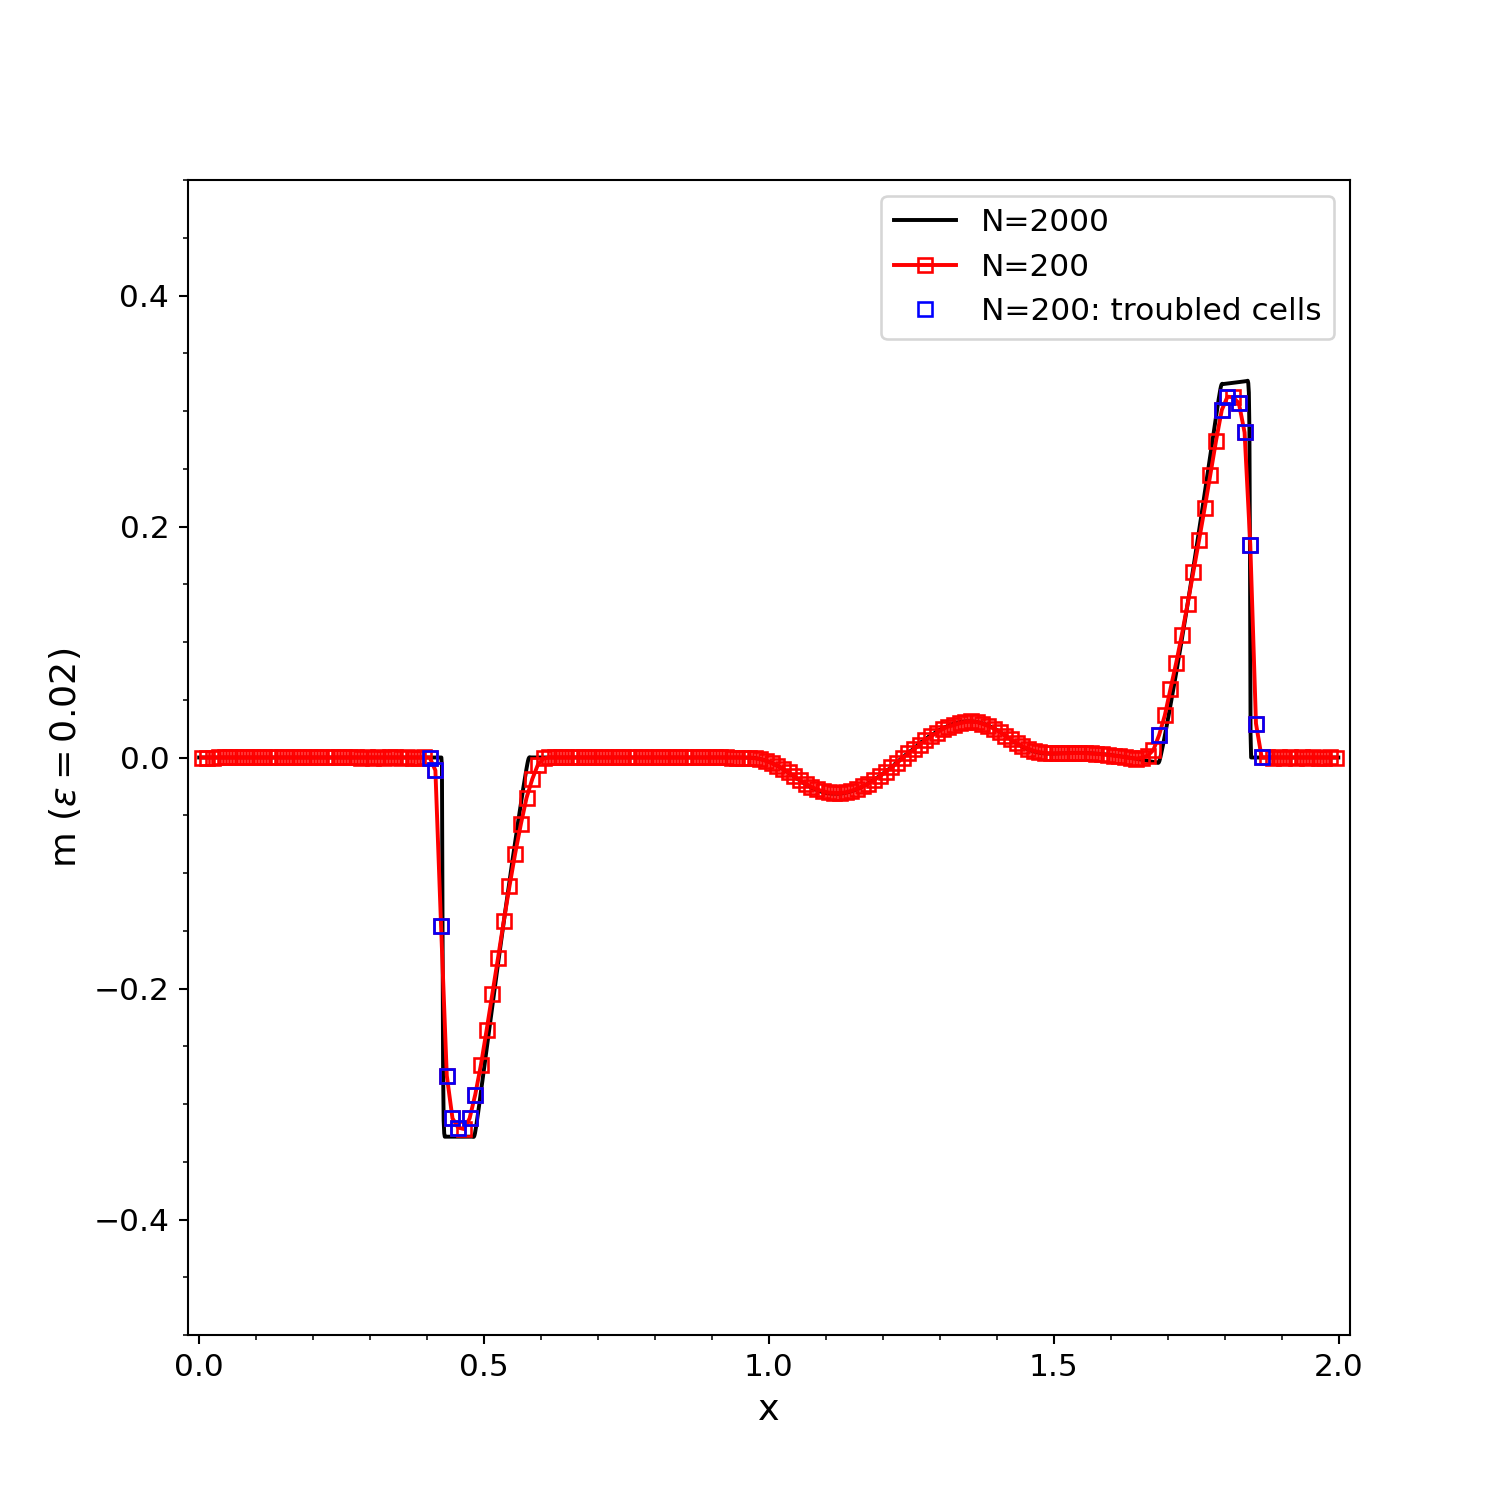

In [44]:
### 2b: plotting
### water height
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_rho[1]+pnts_b[1],'k-')
ax1.plot(pnts_x[0], pnts_rho[0]+pnts_b[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_rho[0][masks[0]]+pnts_b[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("h+b", fontsize=14)
ax1.set_xlim([-5,1505])
ax1.set_ylim([15,20])
ax1.xaxis.set_minor_locator(MultipleLocator(100))
ax1.xaxis.set_major_locator(MultipleLocator(500))
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.02))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("rho3a.pdf")


### discharge
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1)
ax1.plot(pnts_x[1], pnts_m[1],'k-')
ax1.plot(pnts_x[0], pnts_m[0],'rs-',markersize=5, markerfacecolor="None")
ax1.plot(pnts_x[0][masks[0]], pnts_m[0][masks[0]],'bs',markersize=5, markerfacecolor="None")
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("m", fontsize=14)
ax1.set_xlim([-0.02,2.02])
ax1.set_ylim([-0.5,0.5])
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.set_yticks([-0.4,-0.2,0, .2,0.4])
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
ax1.legend(["N=2000","N=200", "N=200: troubled cells"])
plt.savefig("m3a.pdf")

### Ex4a

In [16]:
# 3a) : discontinuous bottom
nxList = [200]

case = '4a'

k=2
cfl = 0.1
method = "RK3"

# TVB limiting 
tol = 0.02 # THIS TVB indicator tolerance
flag = "char" # THIS IS TVB limiting flag

eps0 = 1e-12 # minimal height

# THIS HACK IS NEEDED FOR 4a (drying/wetting) only
maxV = 0
epsRho = 5e-3 # minimal percentage of height

pcBot = False
limitB = True # limit (h+b, m) as indicator 

# generate data
pnts_x = []
pnts_rho = []
pnts_b=[]
pnts_u=[]
pnts_m=[]
masks = []
for i, nx in enumerate(nxList):
    pnts_x0, pnts_rho0, pnts_b0, pnts_u0, pnts_m0, mask, rhoh, bh, uh, mh = FVSolveBot(case=case, 
                                    nx = nx, k=k, cfl =cfl, method=method, 
                                    eps0=eps0, epsRho=epsRho, plot=False, tol=tol, maxV = maxV,
                                    flag=flag, pcBot=pcBot, limitB=limitB)
    pnts_x.append(pnts_x0)
    pnts_rho.append(pnts_rho0[-1])
    pnts_b.append(pnts_b0[-1])
    pnts_u.append(pnts_u0[-1])
    pnts_m.append(pnts_m0[-1])
    masks.append(mask)
    print(nx, "...done")
    


200 ...done
